In [1]:
import numpy as np
import matplotlib.pyplot as plt

Plot Lennard-Jones Potential

Text(0, 0.5, 'U / ε')

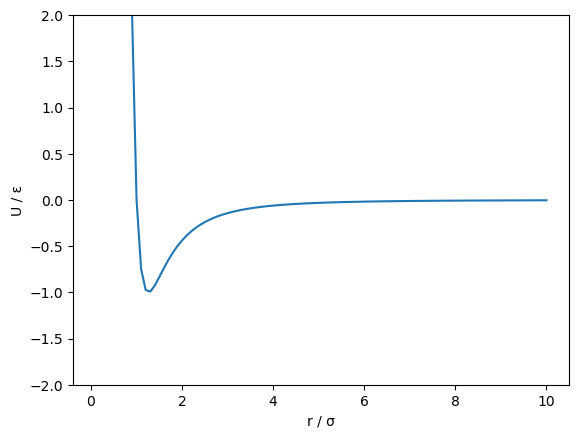

In [107]:
x = np.linspace(0.1, 10, 100)
r2i = 1 / x
r6i = r2i**3
 
ecut = 0
y = 4 * r6i * (r6i - 1) - ecut
plt.plot(x,y)
plt.ylim(-2, 2)
plt.xlabel('r / σ')
plt.ylabel('U / ε')

#here epsilon = 1 and sigma = 1 

In [18]:
import matplotlib.pyplot as plt

class MD:
    def __init__(self, n_particles, box_length, temperature, dt=0.005, read_positions=False):
        self.n_particles = n_particles
        self.box_length = box_length
        self.temperature = temperature
        self.dt = dt
        self.read_positions = read_positions
        self.positions, self.old_positions, self.velocities, self.U_kin = self.initialise_system(read_positions)
        # self.positions, self.old_positions, self.velocities, self.U_kin = self.initialise_system_random()

        self.forces, self.potential_energy, self.pressure = self.calculate_forces()



    def initialise_system(self, read_positions):

        if read_positions:
            positions = np.load('positions.npy')[-1]
        else:
            positions = np.zeros((self.n_particles, 3))

            n_per_dim = int(np.ceil(self.n_particles ** (1/3)))

            # Calculate the spacing between particles
            spacing = self.box_length / n_per_dim

            counter = 0

            # Place particles on a lattice
            for i in range(n_per_dim):
                for j in range(n_per_dim):
                    for k in range(n_per_dim):
                        if counter < self.n_particles:
                            positions[counter] = np.array([i, j, k]) * spacing
                            counter += 1
        
        old_positions = np.zeros((self.n_particles, 3))
        velocities = np.zeros((self.n_particles, 3))
        forces = np.zeros((self.n_particles, 3))

        # Initialize velocities with Maxwell-Boltzmann distribution
        velocities = np.random.normal(0, np.sqrt(self.temperature), (self.n_particles, 3))

        # Remove center of mass motion
        momentum = np.sum(velocities, axis=0) / self.n_particles
        velocities -= momentum

        # Rescale velocities to match desired temperature
        kinetic_energy = 0.5 * np.sum(velocities**2)
        scale_factor = np.sqrt((3 * self.n_particles * self.temperature) / (2 * kinetic_energy))
        velocities *= scale_factor

        # Get old position
        old_positions = positions - velocities * self.dt

        return positions, old_positions, velocities, kinetic_energy
    

    def initialise_system_random(self):


        def check_overlap(positions, new_position, cutoff):
            for position in positions:
                if np.linalg.norm(position - new_position) < cutoff:
                    return True

        positions = np.zeros((self.n_particles, 3))
        for i in range(self.n_particles):
            print(i)
            n_trials = 0
            cutoff = 1.122
            trial_position = np.random.rand(3) * self.box_length
            while check_overlap(positions, trial_position, cutoff):
                trial_position = np.random.rand(3) * self.box_length
                n_trials += 1
                if n_trials > 1000:
                    print('Reducing cutoff')
                    cutoff -= 0.05
            positions[i] = trial_position

        positions = np.random.rand(self.n_particles, 3) * self.box_length
        velocities = np.random.normal(0, np.sqrt(self.temperature), (self.n_particles, 3))
        momentum = np.sum(velocities, axis=0) / self.n_particles
        velocities -= momentum
        kinetic_energy = 0.5 * np.sum(velocities**2)
        scale_factor = np.sqrt((3 * self.n_particles * self.temperature) / (2 * kinetic_energy))
        velocities *= scale_factor
        old_positions = positions - velocities * self.dt
        return positions, old_positions, velocities, kinetic_energy


    def calculate_forces(self):
        forces = np.zeros((self.n_particles, 3))
        potential_energy = 0.0
        pressure = 0.0
        
        cutoff = 0.5 * self.box_length 
        cutoff2 = cutoff ** 2
        ecut = 4 * (cutoff**-12 - cutoff**-6)  # Correct cutoff energy shift
        
        for i in range(self.n_particles):
            for j in range(i + 1, self.n_particles):
                xr = self.positions[i] - self.positions[j]
                # Minimum image convention (PBC)
                xr -= self.box_length * np.round(xr / self.box_length)
                r2 = np.dot(xr, xr)
                
                if r2 < cutoff2:  
                    r2i = 1.0 / r2
                    r6i = r2i ** 3
                    force_magnitude = 48 * r2i * r6i * (r6i - 0.5)  # LJ potential force magnitude
                    force = force_magnitude * xr
                    
                    forces[i] += force
                    forces[j] -= force
                
                    potential_energy += 4 * r6i * (r6i - 1) - ecut  # Shifted LJ potential
                    pressure += np.dot(force, xr)
        
        # Pressure normalization
        pressure /= (3.0 * self.box_length ** 3)
        
        return forces, potential_energy, pressure

   
    def euler(self):
        new_positions = self.positions + self.velocities * self.dt + 0.5 * self.forces * self.dt ** 2
        self.positions = new_positions
        new_velocities = self.velocities + 0.5 * self.forces * self.dt
        self.velocities = new_velocities

    def verlet(self):

        new_positions = np.zeros((self.n_particles, 3))
        new_positions = 2.0 * self.positions - self.old_positions + (self.forces * self.dt ** 2)
        self.velocities = (new_positions - self.old_positions) / (2.0 * self.dt)
        self.U_kin = 0.5 * np.sum(self.velocities**2)
        self.old_positions = self.positions
        self.positions = new_positions

    def velocity_verlet(self):
        # 1. Half-step velocity update
        velocities_half = self.velocities + 0.5 * self.forces * self.dt
        
        # 2. Full position update
        self.positions += velocities_half * self.dt
        
        # 3. Recalculate forces based on the new positions
        self.forces, self.potential_energy, self.pressure = self.calculate_forces()
        
        # 4. Full-step velocity update using the new forces
        self.velocities = velocities_half + 0.5 * self.forces * self.dt


            
    def calculate_temperature(self):
        # Calculate kinetic energy
        kinetic_energy = 0.5 * np.sum(self.velocities**2)
        # Calculate temperature
        temperature = (2 * kinetic_energy) / (3 * self.n_particles)
        return temperature

    def do_MD(self, n_steps, integrator):

        properties = np.zeros((n_steps, 5))
        positions = np.zeros((n_steps, self.n_particles, 3))
        for step in range(n_steps):

            self.forces, self.potential_energy, self.pressure = self.calculate_forces()
            if integrator == 'euler':
                self.euler()
            elif integrator == 'velocity_verlet':
                self.velocity_verlet()
            else:
                print('Must choose an integrator: euler or velocity_verlet')
                
            kinetic_energy = 0.5 * np.sum(self.velocities**2)
            total_energy = kinetic_energy + self.potential_energy
            temperature = self.calculate_temperature()
            properties[step] = np.array([step, kinetic_energy, self.potential_energy, total_energy, temperature])
            positions[step][:] = self.positions
            header = "# step kinetic_energy potential_energy total_energy temperature"

            print(f"Step {step}, Kinetic Energy: {kinetic_energy:.3f}, Potential Energy: {self.potential_energy:.3f}, Total Energy: {total_energy:.3f}, Temperature: {temperature:.2f}")
        np.savetxt('data.txt', properties, header=header, comments='', fmt='%.8f')
        np.save('positions.npy', positions)


        return positions, properties



Set up MD settings

In [30]:
# Set Argon parameters
n_particles = 125
sigma_ar = 3.4E-10  # Lennard-Jones sigma for argon in meters
kb = 1.38064852E-23  # Boltzmann constant in J/K
epsilon_ar = 120 * kb  # Argon epsilon in J
mass_ar = 39.95 * 1.6747E-24  # Argon mass in grams
temperature = 94.4  # Argon temperature in K
density = 1.374 * 1E6  # In g/m^3
dt = 1E-14  # Time step in seconds
box_length = (mass_ar * n_particles / (density)) ** (1/3) #metres

box_length_star = box_length / sigma_ar # In LJ units
print('box_length*',box_length_star)

temperature_star = temperature * kb / epsilon_ar # In LJ units
print('T*',temperature_star)

dt_star = dt / (sigma_ar * np.sqrt(mass_ar / epsilon_ar)) # In LJ units
print('dt*',dt_star)

print('SI',n_particles, box_length, temperature, dt)
n_particles = 125
box_length = box_length_star  # In LJ units, 10σ
temperature = temperature_star  # In LJ units, kB*T/ε = 1.0
dt = dt_star  # Time step in LJ units 
print('LJ units',n_particles, box_length_star, temperature_star, dt_star)



box_length* 5.370072030161947
T* 0.7866666666666667
dt* 0.0001463613375934729
SI 125 1.8258244902550621e-09 94.4 1e-14
reduced 125 5.370072030161947 0.7866666666666667 0.0001463613375934729
Step 0, Kinetic Energy: 147.537, Potential Energy: -598.936, Total Energy: -451.398, Temperature: 0.79
Step 1, Kinetic Energy: 147.575, Potential Energy: -598.974, Total Energy: -451.398, Temperature: 0.79
Step 2, Kinetic Energy: 147.614, Potential Energy: -599.012, Total Energy: -451.398, Temperature: 0.79
Step 3, Kinetic Energy: 147.653, Potential Energy: -599.051, Total Energy: -451.398, Temperature: 0.79
Step 4, Kinetic Energy: 147.692, Potential Energy: -599.091, Total Energy: -451.398, Temperature: 0.79
Step 5, Kinetic Energy: 147.732, Potential Energy: -599.130, Total Energy: -451.398, Temperature: 0.79
Step 6, Kinetic Energy: 147.773, Potential Energy: -599.171, Total Energy: -451.398, Temperature: 0.79
Step 7, Kinetic Energy: 147.813, Potential Energy: -599.212, Total Energy: -451.398, Temp

Run short high temperature simulation to melt Argon

In [ ]:
# Initialise MD simulation
md_simulation = MD(n_particles, box_length_star, temperature_star, dt_star, read_positions = False)

n_steps = 1000

# Run MD simulation
positions, properties = md_simulation.do_MD(n_steps, integrator='velocity_verlet')


Run simulation at target temperature

In [ ]:
# Run MD simulation
md_simulation = MD(n_particles, box_length_star, temperature_star, dt_star, read_positions=True)
n_steps = 10000
positions, properties = md_simulation.do_MD(n_steps, integrator='velocity_verlet')


Check energy is conserved over simulation

Text(0, 0.5, 'Total Energy')

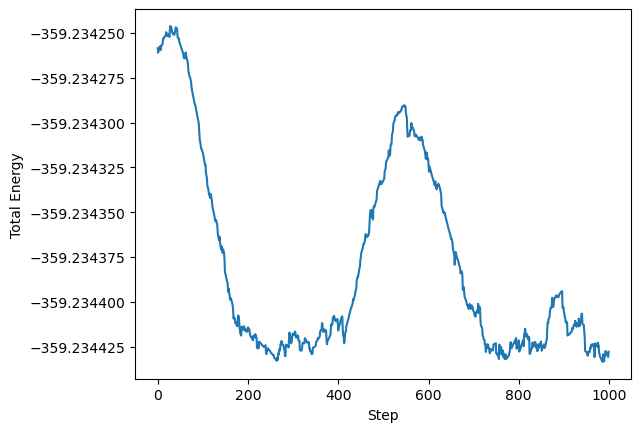

In [23]:
fig, ax = plt.subplots()
data = np.loadtxt('data.txt')
tot_energy = data[:,3]

ax.plot(np.arange(n_steps), tot_energy)
ax.ticklabel_format(style='plain')
ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.set_xlabel('Step')
ax.set_ylabel('Total Energy')
# ax.set_ylim(-480, -460)

Get Radial Distribution Function

In [28]:
positions = np.load('positions.npy')
import ase.io
from ase import Atoms
from ase.visualize import view
#import ase.write
md_system = MD(n_particles, box_length, temperature, dt)
for idx, i in enumerate(positions):
    system = Atoms(['Ar'] * md_system.n_particles, positions = i * sigma_ar*1E10)
    system.set_cell([box_length_star * sigma_ar*1E10, box_length_star * sigma_ar*1E10, box_length_star * sigma_ar*1E10])
    if idx == 0:
        ase.io.write('argon.xyz', system, append = False)
    else:
        ase.io.write('argon.xyz', system, append = True)

In [24]:
positions = np.load('positions.npy')


In [25]:
positions.shape

(1000, 125, 3)

In [31]:
positions = np.load('positions.npy')

def get_rdf(positions, nbins=100):
    gr = np.zeros((nbins,2))
    dg = box_length / (2 * nbins)

    bin_index = 0
    for k in range(positions.shape[0]):
        print(k)
        for i in range(n_particles):
            for j in range(i+1, n_particles):
                rij = positions[k][i] - positions[k][j]
                rij -= box_length * np.round(rij / box_length)
                r = np.linalg.norm(rij)
                if r < box_length / 2:
                    bin_index = int(r / dg)
                    gr[bin_index][1] += 2
    
    for i in range(nbins): #final normalisation
        r = (i + 0.5) * dg
        v = (4 * np.pi / 3) * (n_particles / box_length**3) * dg**3 * ((i + 1) **3 - i**3)
        gr[i][1] /= (v * n_particles)
        gr[i][0] = r

    return gr

rdf = get_rdf(positions)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

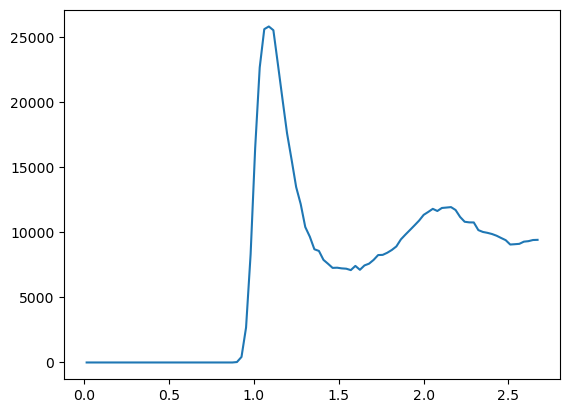

In [32]:
bins = rdf[:,0]
g = rdf[:,1]
plt.plot(bins  , g)   

In [111]:
import ase
from ase import Atoms
from ase.visualize import view
#import ase.write
md_system = MD(n_particles, box_length, temperature, dt)
system = Atoms(['Ar'] * md_system.n_particles, positions = md_system.positions * sigma_ar*1E10)
system.set_cell([box_length_star * sigma_ar*1E10, box_length_star * sigma_ar*1E10, box_length_star * sigma_ar*1E10])
ase.io.write('argon.xyz', system)

In [129]:
positions.shape

(100000, 125, 3)

In [131]:
import ase
from ase import Atoms
from ase.visualize import view
#import ase.write
md_system = MD(n_particles, box_length, temperature, dt)
for idx, i in enumerate(positions):
    system = Atoms(['Ar'] * md_system.n_particles, positions = i * sigma_ar*1E10)
    system.set_cell([box_length_star * sigma_ar*1E10, box_length_star * sigma_ar*1E10, box_length_star * sigma_ar*1E10])
    if idx == 0:
        ase.io.write('argon.xyz', system, append = False)
    else:
        ase.io.write('argon.xyz', system, append = True)

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/nco24/software/anaconda3/envs/caco3/lib/python3.12/site-packages/ase/visualize/viewers.py", line 265, in <module>
    cli_main()
  File "/home/nco24/software/anaconda3/envs/caco3/lib/python3.12/site-packages/ase/visualize/viewers.py", line 261, in cli_main
    cli_viewer.view_blocking(atoms, data)
  File "/home/nco24/software/anaconda3/envs/caco3/lib/python3.12/site-packages/ase/visualize/viewers.py", line 114, in view_blocking
    with self.mktemp(atoms, data) as path:
  File "/home/nco24/software/anaconda3/envs/caco3/lib/python3.12/contextlib.py", line 137, in __enter__
    return next(self.gen)
           ^^^^^^^^^^^^^^
  File "/home/nco24/software/anaconda3/envs/caco3/lib/python3.12/site-packages/ase/visualize/viewers.py", line 108, in mktemp
    write(fd, atoms, format=self.fmt)
  File "/home/nco24/software/anaconda3/envs/caco3/l

KeyboardInterrupt: 

In [124]:
from ase import Atoms
import ase.io

# Prepare the ASE Trajectory writer
traj = ase.io.Trajectory('argon.xyz', 'w')

# Loop over all time steps
for i in range(positions.shape[0]):
    # Get positions for the current time step
    current_positions = positions[i]  # Shape (125, 3)
    
    # Create an ASE Atoms object for the current time step
    system = Atoms(['Ar'] * md_system.n_particles, positions=current_positions * sigma_ar * 1E10)
    
    # Set the simulation box (assuming cubic box, adjust if necessary)
    system.set_cell([box_length_star * sigma_ar * 1E10] * 3)
    
    # Append to the trajectory
    traj.write(system)

# Close the trajectory writer
traj.close()

KeyboardInterrupt: 

In [125]:
sys = (ase.io.read('argon.xyz', index=':'))

In [127]:
len(sys)

33680

In [120]:
view(sys)

<Popen: returncode: None args: ['/home/nco24/software/anaconda3/envs/caco3/b...>

In [123]:
from ase.geometry.analysis import Analysis
Analysis.get_rdf(sys, rmax = 5, nbins = 100)

AttributeError: 'list' object has no attribute '_get_slice'